# Used Libraries

In [1]:
import pandas as pd

import numpy as np

from datasets import load_dataset

import matplotlib.pyplot as plt

import re

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.pipeline import Pipeline

# Importing and Preparing the Dataset

## Loading and Combining the Different Splits of the Dataset

In [2]:
# Load the SST dataset's training split

train_data = load_dataset('sst', split='train', trust_remote_code=True)

train_data = pd.DataFrame(train_data)



# Load the SST dataset's validation split

val_data = load_dataset('sst', split='validation', trust_remote_code=True)

val_data = pd.DataFrame(val_data)



# Load the SST dataset's test split

test_data = load_dataset('sst', split='test', trust_remote_code=True)

test_data = pd.DataFrame(test_data)



# concatenate the training and validation data and the test data

data = pd.concat([train_data, val_data, test_data])



# deleting splits to save memory

del train_data, val_data, test_data


## Mapping the Scores and Cleaning the Dataset

In [3]:
def score_to_class(score):

    if score <= 0.2:

        return 0

    elif score <= 0.4:

        return 1

    elif score <= 0.6:

        return 2

    elif score <= 0.8:

        return 3

    else:

        return 4



def clean_text(text):

    # Allow alphabetic characters, spaces, and specified punctuation symbols

    text = re.sub(r'[^a-zA-Z\s\.\!\?\:\;]', '', text)

    # Remove consecutive spaces

    text = re.sub(r'\s+', ' ', text).strip()

    return text





# Apply cleaning and score mapping on each dataset

data['sentence'] = data['sentence'].apply(lambda x: clean_text(x.lower()))

data['label'] = data['label'].apply(lambda x: score_to_class(x))



# Display cleaned samples from each data

print("Data samples after cleaning:")

print(data.head())


Data samples after cleaning:
                                            sentence  label  \
0  the rock is destined to be the st century s ne...      3   
1  the gorgeously elaborate continuation of the l...      4   
2  singercomposer bryan adams contributes a slew ...      3   
3  you d think by now america would have had enou...      2   
4               yet the act is still charming here .      3   

                                              tokens  \
0  The|Rock|is|destined|to|be|the|21st|Century|'s...   
1  The|gorgeously|elaborate|continuation|of|``|Th...   
2  Singer\/composer|Bryan|Adams|contributes|a|sle...   
3  You|'d|think|by|now|America|would|have|had|eno...   
4               Yet|the|act|is|still|charming|here|.   

                                                tree  
0  70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|5...  
1  71|70|69|69|67|67|66|64|63|62|62|61|61|58|57|5...  
2  72|71|71|70|68|68|67|67|66|63|62|62|60|60|58|5...  
3  36|35|34|33|33|32|30|29|27|26|25

## Distribution of Labels in the Dataset

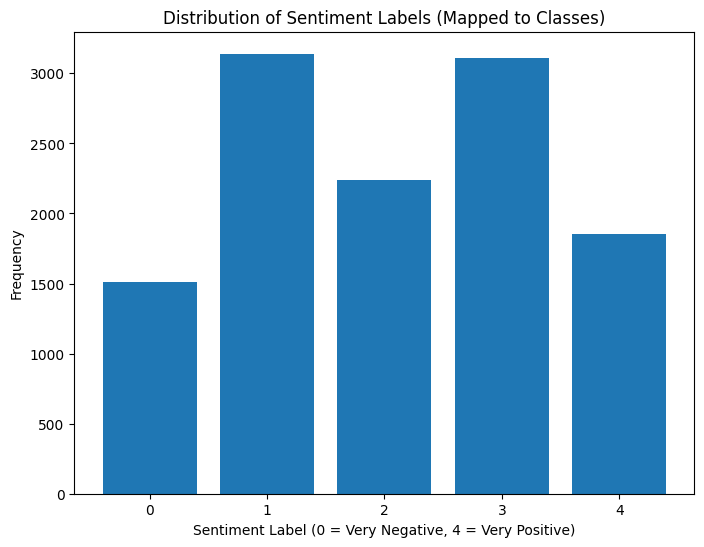

In [4]:
# Plotting the distribution of sentiment labels after mapping scores to classes

data_label_counts = data['label'].value_counts().sort_index()

plt.figure(figsize=(8, 6))

plt.bar(data_label_counts.index, data_label_counts.values)

plt.xlabel("Sentiment Label (0 = Very Negative, 4 = Very Positive)")

plt.ylabel("Frequency")

plt.title("Distribution of Sentiment Labels (Mapped to Classes)")

plt.show()


## Dividing the Dataset Based on the Label's Distribution

In [5]:
#divide the data into training 90% and testing 10% so that both have the same distribution of sentiment labels

train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)

del data



# Display a few samples from the train and test sets to verify the split

print("Training data samples:")

print(train_data.head())

print("\nTesting data samples:")

print(test_data.head())



# Display the distribution of labels in the training and test sets to verify the stratification

print("\nLabel distribution in training data:")

print(train_data['label'].value_counts(normalize=True))

print("\nLabel distribution in testing data:")

print(test_data['label'].value_counts(normalize=True))

Training data samples:
                                               sentence  label  \
2134  usually when i get this much syrup i like panc...      1   
1053  mattei is tiresomely grave and longwinded as i...      0   
6071  goodlooking but relentlessly lowbrow outing pl...      1   
807   do nt be fooled by the impressive cast list ey...      0   
2087        sushi for the connoisseurs of the macabre .      1   

                                                 tokens  \
2134  Usually|when|I|get|this|much|syrup|,|I|like|pa...   
1053  Mattei|is|tiresomely|grave|and|long-winded|,|a...   
6071  Good-looking|but|relentlessly|lowbrow|outing|p...   
807   Do|n't|be|fooled|by|the|impressive|cast|list|-...   
2087        Sushi|for|the|connoisseurs|of|the|macabre|.   

                                                   tree  
2134  30|29|28|27|26|25|25|24|23|21|20|19|18|17|17|2...  
1053  27|23|22|20|20|21|24|19|18|17|16|15|15|26|16|1...  
6071  20|20|21|19|19|17|16|15|14|13|13|18|14|15|16|

In [6]:
# create x and y train

x_train = train_data['sentence']

y_train = train_data['label']



# create x and y test

x_test = test_data['sentence']

y_test = test_data['label']

# Part 1: Naïve Bayes

## Naïve Bayes Custome Implementation

In [7]:
def train_naive_bayes(data: pd.DataFrame):

    # Get the number of docs and classes of the data

    n = len(data)

    classes = data['label'].unique().tolist()



    # Construct vocabulary, and count of each word and total word count in each class

    vocab = set()

    vocab_counts = {}

    class_word_counts = {}

    # Loop over each sentence-class pair

    for sentence, c in zip(data['sentence'].tolist(), data['label'].tolist()):

        for word in sentence.split():  # Loop over each word

            vocab_counts[(word, c)] = vocab_counts.get((word, c), 0) + 1  # Increment count of word in that class

            class_word_counts[c] = class_word_counts.get(c, 0) + 1  # Increment number of words in that class

            vocab.add(word)  # Add word to the vocabulary set



    # Calculate log versions of prior probabilities p(c) and posterior probabilities for each word p(w|c)

    log_prior = {}

    log_likelihood = {}

    for c in classes:

        log_prior[c] = np.log(np.sum(data['label'] == c) / n)

        for word in vocab:

            log_likelihood[(word, c)] = np.log(

                (vocab_counts.get((word, c), 0) + 1) / (class_word_counts[c] + len(vocab)))



    return log_prior, log_likelihood, vocab





def test_naive_bayes(test_doc: str, log_prior: dict, log_likelihood: dict, classes: list[int], vocab: set):

    # Initialize all scores to 0

    score = [0] * len(classes)

    # Loop over each class and calculate the score of this class given the test doc

    for c_i, c in enumerate(classes):

        score[c_i] = log_prior[c]  # Initialize score to log prior probability

        # Add likelihood of each word in the sentence given current class (if it was in the vocabulary)

        for word in test_doc.lower().split():

            if word in vocab:

                score[c_i] += log_likelihood[(word, c)]

    # Return class with the max score

    return classes[np.argmax(score)]

## Custom Implementation Accuracy of the Naïve Bayes Classifier

In [8]:
def compute_accuracy(test_data: pd.DataFrame, log_prior: dict, log_likelihood: dict, classes: list[int], vocab: set):

    correct_predictions = 0

    total_predictions = len(test_data)

    

    for sentence, true_label in zip(test_data['sentence'], test_data['label']):

        predicted_label = test_naive_bayes(sentence, log_prior, log_likelihood, classes, vocab)

        if predicted_label == true_label:

            correct_predictions += 1

    

    accuracy = correct_predictions / total_predictions

    return accuracy



# Train the Naive Bayes model

log_prior, log_likelihood, vocab = train_naive_bayes(train_data)

classes = train_data['label'].unique().tolist()



# Compute accuracy on the test set

accuracy = compute_accuracy(test_data, log_prior, log_likelihood, classes, vocab)



# Generate predictions on the test set using the custom Naive Bayes classifier

predicted_labels_custom_naïve_bayes = [test_naive_bayes(sentence, log_prior, log_likelihood, classes, vocab) for sentence in test_data['sentence']]



print(f"Accuracy: {accuracy:.12f}")


Accuracy: 0.417369308600


## Scikit Implementation Accuracy of the Naïve Bayes Classifier

In [9]:
# Create a pipeline with CountVectorizer and MultinomialNB

pipeline = Pipeline([

    ('vectorizer', CountVectorizer()),

    ('nb', MultinomialNB(alpha=1.0))  # Use alpha=1 for Laplace smoothing, matching the custom implementation

])



# Train the pipeline on the training data

pipeline.fit(x_train, y_train)



# Make predictions on the test set

predicted_labels_Scikit_naïve_bayes = pipeline.predict(x_test)



# Calculate accuracy

accuracy = accuracy_score(y_test, predicted_labels_Scikit_naïve_bayes)

print(f"Accuracy: {accuracy:.12f}")

Accuracy: 0.416526138280


# Part 2: Logistic Regression

## Preparing the Traning and Testing Labels

In [10]:
#create one hot encoding for y_train, y_val, y_test

def one_hot_encode(y, num_classes):

    v = np.zeros((len(y), num_classes))

    v[np.arange(len(y)), y] = 1

    return v



y_train = one_hot_encode(y_train, 5)

y_test = one_hot_encode(y_test, 5)



print("y_train one-hot encoded shape:", y_train.shape)

print("y_train one-hot encoded:")

print(y_train)

print("-" * 50)

print("y_test one-hot encoded shape:", y_test.shape)

print("y_test one-hot encoded:")

print(y_test)

y_train one-hot encoded shape: (10669, 5)
y_train one-hot encoded:
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
--------------------------------------------------
y_test one-hot encoded shape: (1186, 5)
y_test one-hot encoded:
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


## Finding the Unique Bigrams in the Dataset

In [11]:
# combine x_train and x_test

x_combined = pd.concat([x_train, x_test], axis=0)

print("Combined x shape:", x_combined.shape)



# extract the Bigrams from the combined x sentences

bigrams = []

for sentence in x_combined:

    words = sentence.split(" ")

    for i in range(len(words) - 1):

        bigrams.append((words[i], words[i + 1]))

        

unique_bigrams = set(bigrams)

print("Number of unique bigrams:", len(unique_bigrams))

print("First 10 bigrams:", bigrams[:10])




Combined x shape: (11855,)
Number of unique bigrams: 108088
First 10 bigrams: [('usually', 'when'), ('when', 'i'), ('i', 'get'), ('get', 'this'), ('this', 'much'), ('much', 'syrup'), ('syrup', 'i'), ('i', 'like'), ('like', 'pancakes'), ('pancakes', 'to')]


## Generating the Sparse Matrix for Training and Testing 

In [12]:
# create a sparse matrix for bigrams for colums and sentences for rows

def create_bigram_sparse_matrix(sentences, bigrams):

    bigram_sparse_matrix = np.zeros((len(sentences), len(bigrams)))

    bigram_to_index = {bigram: i for i, bigram in enumerate(bigrams)}

    for i, sentence in enumerate(sentences):

        words = sentence.split(" ")

        for j in range(len(words) - 1):

            bigram = (words[j], words[j + 1])

            bigram_sparse_matrix[i, bigram_to_index[bigram]] = 1

    return bigram_sparse_matrix



x_train_bigram_sparse = create_bigram_sparse_matrix(x_train, unique_bigrams)

x_test_bigram_sparse = create_bigram_sparse_matrix(x_test, unique_bigrams)



print("x_train_bigram_sparse shape:", x_train_bigram_sparse.shape)

print("x_test_bigram_sparse shape:", x_test_bigram_sparse.shape)

x_train_bigram_sparse shape: (10669, 108088)
x_test_bigram_sparse shape: (1186, 108088)


## Logistic Regression Custom Implementation

In [13]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred, weights, alpha):
    # Cross-entropy loss with L2 regularization
    base_loss = -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))
    l2_penalty = (alpha / 2) * np.sum(weights**2)  # L2 regularization term
    return base_loss + l2_penalty

def accuracy(y_true, y_pred):
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    return np.mean(y_true_labels == y_pred_labels)

class LogisticRegressionCustom:
    def __init__(self, num_features, alpha=0.01):
        self.num_features = num_features
        self.alpha = alpha  # Regularization strength
        # (Glorot) Initialization for the weights
        self.weights = np.random.uniform(
            -np.sqrt(6 / (num_features + 5)), 
            np.sqrt(6 / (num_features + 5)), 
            (num_features, 5)
        ) * 0.001
        self.bias = np.zeros(5)
        
    def forward(self, x):
        return softmax(np.dot(x, self.weights) + self.bias)
    
    def backward(self, x, y_true, y_pred, learning_rate):
        # Calculate the gradients
        m = len(y_true)
        grad_w = np.dot(x.T, (y_pred - y_true)) / m  # Gradient for weights (vectorized)
        grad_b = np.sum(y_pred - y_true, axis=0) / m  # Gradient for biases (vectorized)
        
        # Add L2 regularization term to the weight gradient
        grad_w += (self.alpha / m) * self.weights  # L2 penalty term for weights
        
        # Update weights and biases
        self.weights -= learning_rate * grad_w
        self.bias -= learning_rate * grad_b
        
    def train(self, x, y, learning_rate, epochs, batch_size=32):
        # History of loss and accuracy
        history = {"loss": [], "accuracy": []}
        
        for epoch in range(epochs):
            # Shuffle the data at the start of each epoch
            indices = np.arange(len(y))
            np.random.shuffle(indices)
            x = x[indices]
            y = y[indices]
            total_loss = 0
            correct_predictions = 0
            
            # Mini-Batch Gradient Descent
            for start in range(0, len(y), batch_size):
                end = start + batch_size
                x_batch = x[start:end]
                y_batch = y[start:end]
                
                # Forward pass
                y_pred = self.forward(x_batch)
                
                # Compute loss and accuracy for the batch
                total_loss += cross_entropy_loss(y_batch, y_pred, self.weights, self.alpha) * len(y_batch)
                correct_predictions += np.sum(np.argmax(y_batch, axis=1) == np.argmax(y_pred, axis=1))
                
                # Backward pass and update weights
                self.backward(x_batch, y_batch, y_pred, learning_rate)
            
            # Record epoch-level loss and accuracy
            avg_loss = total_loss / len(y)
            avg_accuracy = correct_predictions / len(y)
            history["loss"].append(avg_loss)
            history["accuracy"].append(avg_accuracy)
            
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.6f} - Accuracy: {avg_accuracy:.6f}")
        
        return history
            
    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred, self.weights, self.alpha)
        acc = accuracy(y, y_pred)
        print(f"Loss: {loss:.6f} - Accuracy: {acc:.6f}")
        
    def predict(self, x):
        return np.argmax(self.forward(x), axis=1)


## Hyper Parameters

In [26]:
# create the model

lr = 1

epochs = 60

batch_size = 128
alpha = 0.0001

LogisticRegression_model = LogisticRegressionCustom(x_train_bigram_sparse.shape[1],alpha)

## Training the Custom Model

In [27]:
# train the model

history = LogisticRegression_model.train(x_train_bigram_sparse, y_train, lr, epochs, batch_size)

Epoch 1/60 - Loss: 1.556553 - Accuracy: 0.301809
Epoch 2/60 - Loss: 1.435707 - Accuracy: 0.432749
Epoch 3/60 - Loss: 1.336983 - Accuracy: 0.526010
Epoch 4/60 - Loss: 1.252511 - Accuracy: 0.614491
Epoch 5/60 - Loss: 1.178588 - Accuracy: 0.686850
Epoch 6/60 - Loss: 1.112584 - Accuracy: 0.739057
Epoch 7/60 - Loss: 1.053701 - Accuracy: 0.782735
Epoch 8/60 - Loss: 1.002216 - Accuracy: 0.819477
Epoch 9/60 - Loss: 0.955591 - Accuracy: 0.846565
Epoch 10/60 - Loss: 0.913295 - Accuracy: 0.866342
Epoch 11/60 - Loss: 0.875590 - Accuracy: 0.886775
Epoch 12/60 - Loss: 0.841614 - Accuracy: 0.900553
Epoch 13/60 - Loss: 0.810793 - Accuracy: 0.908239
Epoch 14/60 - Loss: 0.782370 - Accuracy: 0.921173
Epoch 15/60 - Loss: 0.756910 - Accuracy: 0.930640
Epoch 16/60 - Loss: 0.733658 - Accuracy: 0.934483
Epoch 17/60 - Loss: 0.712151 - Accuracy: 0.941981
Epoch 18/60 - Loss: 0.693034 - Accuracy: 0.948730
Epoch 19/60 - Loss: 0.674913 - Accuracy: 0.952292
Epoch 20/60 - Loss: 0.658684 - Accuracy: 0.956603
Epoch 21/

## Loss and Accuracy Plot

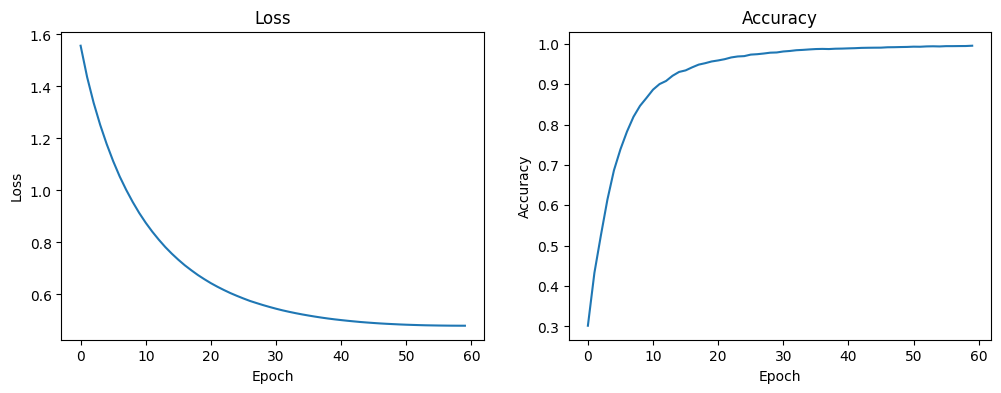

In [28]:
# plot the loss and accuracy

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

plt.plot(history["loss"])

plt.title("Loss")

plt.xlabel("Epoch")

plt.ylabel("Loss")

plt.subplot(1, 2, 2)

plt.plot(history["accuracy"])

plt.title("Accuracy")

plt.xlabel("Epoch")

plt.ylabel("Accuracy")

plt.show()

## Custom Implementation Accuracy and Loss for the Logistic Regression Model

In [29]:
# evaluate the model

print("Train Data:")

LogisticRegression_model.evaluate(x_train_bigram_sparse, y_train)



print("Test Data:")

LogisticRegression_model.evaluate(x_test_bigram_sparse, y_test)

Train Data:
Loss: 0.477510 - Accuracy: 0.995314
Test Data:
Loss: 1.755864 - Accuracy: 0.346543


## Scikit Implementation Accuracy of the SGD Classifier and Logistic Regression Model

In [18]:
# Convert one-hot encoded labels to single-label format
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Initialize the models with specific parameters
sgd_classifier = SGDClassifier(loss="log_loss", penalty="l2", max_iter=150, tol=1e-3)
logistic_regression = LogisticRegression(max_iter=150, tol=1e-3)

# Training the models
sgd_classifier.fit(x_train_bigram_sparse, y_train_1d)
logistic_regression.fit(x_train_bigram_sparse, y_train_1d)

# Predicting the test labels
y_pred_sgd = sgd_classifier.predict(x_test_bigram_sparse)
y_pred_logreg = logistic_regression.predict(x_test_bigram_sparse)

# Calculating the accuracy of the models
accuracy_sgd = accuracy_score(y_test_1d, y_pred_sgd)
accuracy_logreg = accuracy_score(y_test_1d, y_pred_logreg)

# Print the accuracies
print("SGD Classifier Accuracy:", accuracy_sgd)
print("Logistic Regression Accuracy:", accuracy_logreg)

SGD Classifier Accuracy: 0.34654300168634067
Logistic Regression Accuracy: 0.3372681281618887


# Part 3: Confusion Matrix & Evaluation Metrics

## Confusion Matrix & Evaluation Metrics Custom implementation

In [19]:
# Get confusion matrix with rows as actual classes and columns as predicted classes
def get_confusion_matrix_custom(predicted, actual):
    classes = np.unique(actual)
    n = len(classes)
    confusion_matrix = np.zeros((n, n), dtype=int)
    for a, p in zip(actual, predicted):
        confusion_matrix[a, p] += 1
    return confusion_matrix

# Get macro-averaged precision over all classes
def precision_custom(confusion_matrix):
    avg_precision = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fp = np.sum(confusion_matrix[:, c]) - tp
        # Avoid division by zero
        if (tp + fp) > 0:
            avg_precision += tp / (tp + fp)
    return avg_precision / confusion_matrix.shape[0]

# Get macro-averaged recall over all classes
def recall_custom(confusion_matrix):
    avg_recall = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fn = np.sum(confusion_matrix[c, :]) - tp
        # Avoid division by zero
        if (tp + fn) > 0:
            avg_recall += tp / (tp + fn)
    return avg_recall / confusion_matrix.shape[0]

# Get macro-averaged F1 score over all classes
def f1_score_custom(confusion_matrix):
    avg_f1 = 0
    for c in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[c, c]
        fp = np.sum(confusion_matrix[:, c]) - tp
        fn = np.sum(confusion_matrix[c, :]) - tp
        # Calculate precision and recall, avoid division by zero in F1 calculation
        if (tp + fp) > 0:
            precision = tp / (tp + fp)
        else:
            precision = 0
        if (tp + fn) > 0:
            recall = tp / (tp + fn)
        else:
            recall = 0
        if (precision + recall) > 0:
            avg_f1 += 2 * (precision * recall) / (precision + recall)
    return avg_f1 / confusion_matrix.shape[0]


### Evaluation Part 1

In [20]:
actual_labels = test_data['label'].tolist()



# Calculate the confusion matrix for custom naïve bayes

conf_matrix_custom_naïve_bayes = get_confusion_matrix_custom(predicted_labels_custom_naïve_bayes, actual_labels)



# Calculate precision, recall, and F1 score

macro_precision_custom_naïve_bayes = precision_custom(conf_matrix_custom_naïve_bayes)

macro_recall_custom_naïve_bayes = recall_custom(conf_matrix_custom_naïve_bayes)

macro_f1_custom_naïve_bayes = f1_score_custom(conf_matrix_custom_naïve_bayes)



# Calculate the confusion matrix 

conf_matrix_Scikit_naïve_bayes = get_confusion_matrix_custom(predicted_labels_Scikit_naïve_bayes, actual_labels)



# Calculate precision, recall, and F1 score

macro_precision_Scikit_naïve_bayes = precision_custom(conf_matrix_Scikit_naïve_bayes)

macro_recall_Scikit_naïve_bayes = recall_custom(conf_matrix_Scikit_naïve_bayes)

macro_f1_Scikit_naïve_bayes = f1_score_custom(conf_matrix_Scikit_naïve_bayes)



print("Confusion Matrix for Custom Naïve Bayes:")

print(conf_matrix_custom_naïve_bayes)

print(f"\nMacro Precision for Custom Naïve Bayes: {macro_precision_custom_naïve_bayes:.12f}")

print(f"Macro Recall for Custom Naïve Bayes: {macro_recall_custom_naïve_bayes:.12f}")

print(f"Macro F1 Score for Custom Naïve Bayes: {macro_f1_custom_naïve_bayes:.12f}")



print("\nConfusion Matrix for Scikit Naïve Bayes:")

print(conf_matrix_Scikit_naïve_bayes)

print(f"\nMacro Precision for Scikit Naïve Bayes: {macro_precision_Scikit_naïve_bayes:.12f}")

print(f"Macro Recall for Scikit Naïve Bayes: {macro_recall_Scikit_naïve_bayes:.12f}")

print(f"Macro F1 Score for Scikit Naïve Bayes: {macro_f1_Scikit_naïve_bayes:.12f}")

Confusion Matrix for Custom Naïve Bayes:
[[ 15 104   8  24   0]
 [  8 210  21  73   2]
 [  2 104  26  84   9]
 [  1  61  19 197  33]
 [  1  26   6 105  47]]

Macro Precision for Custom Naïve Bayes: 0.444149630204
Macro Recall for Custom Naïve Bayes: 0.354235536268
Macro F1 Score for Custom Naïve Bayes: 0.337730602911

Confusion Matrix for Scikit Naïve Bayes:
[[ 16 103   8  24   0]
 [ 10 210  22  70   2]
 [  3 105  26  82   9]
 [  2  60  22 194  33]
 [  1  28   5 103  48]]

Macro Precision for Scikit Naïve Bayes: 0.432031979374
Macro Recall for Scikit Naïve Bayes: 0.354711860210
Macro F1 Score for Scikit Naïve Bayes: 0.339471607011


### Evaluation Part 2

In [30]:
# Get the confusion matrix for custom logistic regression

conf_matrix_custom_logistic_regression = get_confusion_matrix_custom(LogisticRegression_model.predict(x_test_bigram_sparse), np.argmax(y_test, axis=1))



# Calculate precision, recall, and F1 score using the confusion matrix

macro_precision_custom_logistic_regression = precision_custom(conf_matrix_custom_logistic_regression)

macro_recall_custom_logistic_regression = recall_custom(conf_matrix_custom_logistic_regression)

macro_f1_custom_logistic_regression = f1_score_custom(conf_matrix_custom_logistic_regression)



print("Confusion Matrix for Custom Logistic Regression:\n", conf_matrix_custom_logistic_regression)

print("Macro Precision for Custom Logistic Regression:", macro_precision_custom_logistic_regression)

print("Macro Recall for Custom Logistic Regression:", macro_recall_custom_logistic_regression)

print("Macro F1 Score Score For Custom Logistic Regression:", macro_f1_custom_logistic_regression)



# Get the confusion matrix for scikit-learn logistic regression and SGD classifier

conf_matrix_logistic_regression = get_confusion_matrix_custom(y_pred_logreg, np.argmax(y_test, axis=1))

conf_matrix_sgd_classifier = get_confusion_matrix_custom(y_pred_sgd, np.argmax(y_test, axis=1))



# Calculate precision, recall, and F1 score using the confusion matrix

macro_precision_logistic_regression = precision_custom(conf_matrix_logistic_regression)

macro_recall_logistic_regression = recall_custom(conf_matrix_logistic_regression)

macro_f1_logistic_regression = f1_score_custom(conf_matrix_logistic_regression)



macro_precision_sgd_classifier = precision_custom(conf_matrix_sgd_classifier)

macro_recall_sgd_classifier = recall_custom(conf_matrix_sgd_classifier)

macro_f1_sgd_classifier = f1_score_custom(conf_matrix_sgd_classifier)



print("Confusion Matrix for Scikit Naïve Bayes:\n", conf_matrix_logistic_regression)

print("Macro Precision for Scikit Naïve Bayes:", macro_precision_logistic_regression)

print("Macro Recall for Scikit Naïve Bayes:", macro_recall_logistic_regression)

print("Macro F1 Score Score For Scikit Naïve Bayes:", macro_f1_logistic_regression)



print("Confusion Matrix for SGD Classifier:\n", conf_matrix_sgd_classifier)

print("Macro Precision for SGD Classifier:", macro_precision_sgd_classifier)

print("Macro Recall for SGD Classifier:", macro_recall_sgd_classifier)

print("Macro F1 Score Score For SGD Classifier:", macro_f1_sgd_classifier)

Confusion Matrix for Custom Logistic Regression:
 [[ 19  86  18  26   2]
 [ 36 146  44  71  17]
 [  9  89  41  75  11]
 [  4  69  47 157  34]
 [  5  40  12  80  48]]
Macro Precision for Custom Logistic Regression: 0.3330659570665563
Macro Recall for Custom Logistic Regression: 0.30746016004857235
Macro F1 Score Score For Custom Logistic Regression: 0.3066691429350844
Confusion Matrix for Scikit Naïve Bayes:
 [[ 18  85  20  25   3]
 [ 34 143  53  67  17]
 [  9  91  41  73  11]
 [  3  72  52 148  36]
 [  3  38  15  79  50]]
Macro Precision for Scikit Naïve Bayes: 0.32668216690528185
Macro Recall for Scikit Naïve Bayes: 0.30059920952351626
Macro F1 Score Score For Scikit Naïve Bayes: 0.30084249863921186
Confusion Matrix for SGD Classifier:
 [[ 22  68  19  37   5]
 [ 33 125  45  94  17]
 [  9  67  40  96  13]
 [  3  55  46 168  39]
 [  2  23  14  90  56]]
Macro Precision for SGD Classifier: 0.34194529745763724
Macro Recall for SGD Classifier: 0.3128915885476859
Macro F1 Score Score For SGD

### Ploting Metrics

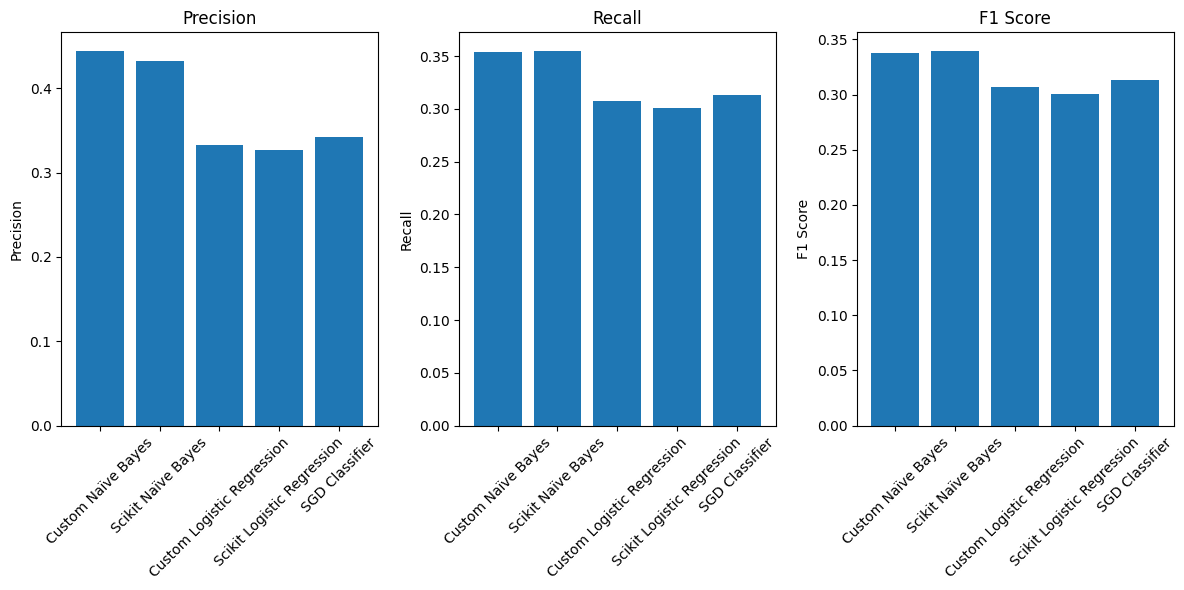

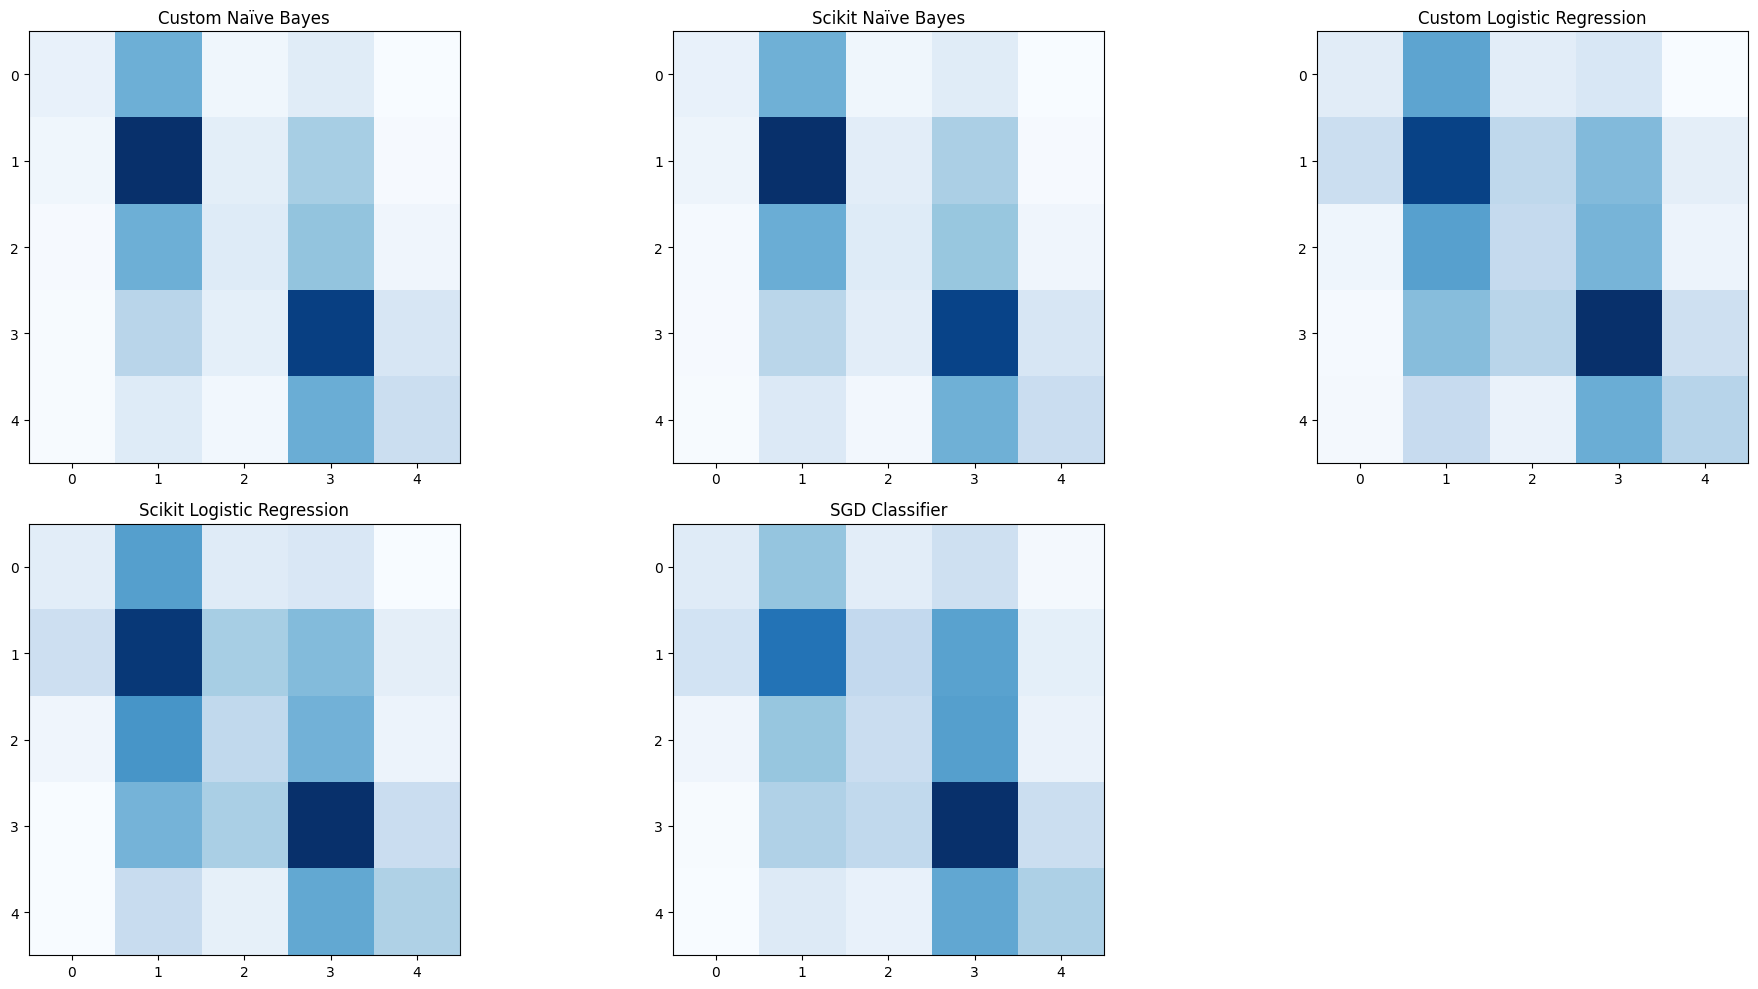

In [31]:
models = ["Custom Naïve Bayes", "Scikit Naïve Bayes", "Custom Logistic Regression", "Scikit Logistic Regression", "SGD Classifier"]

metrics = ["Precision", "Recall", "F1 Score"]

values = [

    [macro_precision_custom_naïve_bayes, macro_recall_custom_naïve_bayes, macro_f1_custom_naïve_bayes],

    [macro_precision_Scikit_naïve_bayes, macro_recall_Scikit_naïve_bayes, macro_f1_Scikit_naïve_bayes],

    [macro_precision_custom_logistic_regression, macro_recall_custom_logistic_regression, macro_f1_custom_logistic_regression],

    [macro_precision_logistic_regression, macro_recall_logistic_regression, macro_f1_logistic_regression],

    [macro_precision_sgd_classifier, macro_recall_sgd_classifier, macro_f1_sgd_classifier]

]



plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):

    plt.subplot(1, 3, i + 1)

    plt.bar(models, [v[i] for v in values])

    plt.title(metric)

    plt.ylabel(metric)

    plt.xticks(rotation=45)

plt.tight_layout()

plt.show()



# plot the confusion matrix for all 5 models next to each other

plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)

plt.title("Custom Naïve Bayes")

plt.imshow(conf_matrix_custom_naïve_bayes, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 2)

plt.title("Scikit Naïve Bayes")

plt.imshow(conf_matrix_Scikit_naïve_bayes, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 3)

plt.title("Custom Logistic Regression")

plt.imshow(conf_matrix_custom_logistic_regression, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 4)

plt.title("Scikit Logistic Regression")

plt.imshow(conf_matrix_logistic_regression, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 5)

plt.title("SGD Classifier")

plt.imshow(conf_matrix_sgd_classifier, cmap="Blues", interpolation="nearest")

plt.tight_layout()

plt.show()

## Confusion Matrix & Evaluation Metrics sklearn implementation

### Evaluation Part 1

In [32]:
# Calculate the confusion matrix for custom Naïve Bayes

conf_matrix_custom_naïve_bayes = confusion_matrix(actual_labels, predicted_labels_custom_naïve_bayes)



# Calculate precision, recall, and F1 score for custom Naïve Bayes

macro_precision_custom_naïve_bayes = precision_score(actual_labels, predicted_labels_custom_naïve_bayes, average='macro')

macro_recall_custom_naïve_bayes = recall_score(actual_labels, predicted_labels_custom_naïve_bayes, average='macro')

macro_f1_custom_naïve_bayes = f1_score(actual_labels, predicted_labels_custom_naïve_bayes, average='macro')



# Calculate the confusion matrix for Scikit Naïve Bayes

conf_matrix_Scikit_naïve_bayes = confusion_matrix(actual_labels, predicted_labels_Scikit_naïve_bayes)



# Calculate precision, recall, and F1 score for Scikit Naïve Bayes

macro_precision_Scikit_naïve_bayes = precision_score(actual_labels, predicted_labels_Scikit_naïve_bayes, average='macro')

macro_recall_Scikit_naïve_bayes = recall_score(actual_labels, predicted_labels_Scikit_naïve_bayes, average='macro')

macro_f1_Scikit_naïve_bayes = f1_score(actual_labels, predicted_labels_Scikit_naïve_bayes, average='macro')



# Print results for Custom Naïve Bayes

print("Confusion Matrix for Custom Naïve Bayes:")

print(conf_matrix_custom_naïve_bayes)

print(f"\nMacro Precision for Custom Naïve Bayes: {macro_precision_custom_naïve_bayes:.12f}")

print(f"Macro Recall for Custom Naïve Bayes: {macro_recall_custom_naïve_bayes:.12f}")

print(f"Macro F1 Score for Custom Naïve Bayes: {macro_f1_custom_naïve_bayes:.12f}")



# Print results for Scikit Naïve Bayes

print("\nConfusion Matrix for Scikit Naïve Bayes:")

print(conf_matrix_Scikit_naïve_bayes)

print(f"\nMacro Precision for Scikit Naïve Bayes: {macro_precision_Scikit_naïve_bayes:.12f}")

print(f"Macro Recall for Scikit Naïve Bayes: {macro_recall_Scikit_naïve_bayes:.12f}")

print(f"Macro F1 Score for Scikit Naïve Bayes: {macro_f1_Scikit_naïve_bayes:.12f}")

Confusion Matrix for Custom Naïve Bayes:
[[ 15 104   8  24   0]
 [  8 210  21  73   2]
 [  2 104  26  84   9]
 [  1  61  19 197  33]
 [  1  26   6 105  47]]

Macro Precision for Custom Naïve Bayes: 0.444149630204
Macro Recall for Custom Naïve Bayes: 0.354235536268
Macro F1 Score for Custom Naïve Bayes: 0.337730602911

Confusion Matrix for Scikit Naïve Bayes:
[[ 16 103   8  24   0]
 [ 10 210  22  70   2]
 [  3 105  26  82   9]
 [  2  60  22 194  33]
 [  1  28   5 103  48]]

Macro Precision for Scikit Naïve Bayes: 0.432031979374
Macro Recall for Scikit Naïve Bayes: 0.354711860210
Macro F1 Score for Scikit Naïve Bayes: 0.339471607011


### Evaluation Part 2

In [33]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score



# Convert one-hot encoded `y_test` to single-label format

actual_labels = np.argmax(y_test, axis=1)



# Predictions for Custom Logistic Regression

predicted_labels_custom_logistic_regression = LogisticRegression_model.predict(x_test_bigram_sparse)



# Calculate confusion matrix, precision, recall, and F1 score for custom Logistic Regression

conf_matrix_custom_logistic_regression = confusion_matrix(actual_labels, predicted_labels_custom_logistic_regression)

macro_precision_custom_logistic_regression = precision_score(actual_labels, predicted_labels_custom_logistic_regression, average='macro')

macro_recall_custom_logistic_regression = recall_score(actual_labels, predicted_labels_custom_logistic_regression, average='macro')

macro_f1_custom_logistic_regression = f1_score(actual_labels, predicted_labels_custom_logistic_regression, average='macro')



# Print results for Custom Logistic Regression

print("Confusion Matrix for Custom Logistic Regression:")

print(conf_matrix_custom_logistic_regression)

print("Macro Precision for Custom Logistic Regression:", macro_precision_custom_logistic_regression)

print("Macro Recall for Custom Logistic Regression:", macro_recall_custom_logistic_regression)

print("Macro F1 Score for Custom Logistic Regression:", macro_f1_custom_logistic_regression)



# Calculate confusion matrix, precision, recall, and F1 score for scikit-learn Logistic Regression

conf_matrix_logistic_regression = confusion_matrix(actual_labels, y_pred_logreg)

macro_precision_logistic_regression = precision_score(actual_labels, y_pred_logreg, average='macro')

macro_recall_logistic_regression = recall_score(actual_labels, y_pred_logreg, average='macro')

macro_f1_logistic_regression = f1_score(actual_labels, y_pred_logreg, average='macro')



# Print results for Scikit-Learn Logistic Regression

print("\nConfusion Matrix for Scikit-Learn Logistic Regression:")

print(conf_matrix_logistic_regression)

print("Macro Precision for Scikit-Learn Logistic Regression:", macro_precision_logistic_regression)

print("Macro Recall for Scikit-Learn Logistic Regression:", macro_recall_logistic_regression)

print("Macro F1 Score for Scikit-Learn Logistic Regression:", macro_f1_logistic_regression)



# Calculate confusion matrix, precision, recall, and F1 score for scikit-learn SGD Classifier

conf_matrix_sgd_classifier = confusion_matrix(actual_labels, y_pred_sgd)

macro_precision_sgd_classifier = precision_score(actual_labels, y_pred_sgd, average='macro')

macro_recall_sgd_classifier = recall_score(actual_labels, y_pred_sgd, average='macro')

macro_f1_sgd_classifier = f1_score(actual_labels, y_pred_sgd, average='macro')



# Print results for Scikit-Learn SGD Classifier

print("\nConfusion Matrix for SGD Classifier:")

print(conf_matrix_sgd_classifier)

print("Macro Precision for SGD Classifier:", macro_precision_sgd_classifier)

print("Macro Recall for SGD Classifier:", macro_recall_sgd_classifier)

print("Macro F1 Score for SGD Classifier:", macro_f1_sgd_classifier)

Confusion Matrix for Custom Logistic Regression:
[[ 19  86  18  26   2]
 [ 36 146  44  71  17]
 [  9  89  41  75  11]
 [  4  69  47 157  34]
 [  5  40  12  80  48]]
Macro Precision for Custom Logistic Regression: 0.3330659570665563
Macro Recall for Custom Logistic Regression: 0.30746016004857235
Macro F1 Score for Custom Logistic Regression: 0.3066691429350844

Confusion Matrix for Scikit-Learn Logistic Regression:
[[ 18  85  20  25   3]
 [ 34 143  53  67  17]
 [  9  91  41  73  11]
 [  3  72  52 148  36]
 [  3  38  15  79  50]]
Macro Precision for Scikit-Learn Logistic Regression: 0.32668216690528185
Macro Recall for Scikit-Learn Logistic Regression: 0.30059920952351626
Macro F1 Score for Scikit-Learn Logistic Regression: 0.30084249863921186

Confusion Matrix for SGD Classifier:
[[ 22  68  19  37   5]
 [ 33 125  45  94  17]
 [  9  67  40  96  13]
 [  3  55  46 168  39]
 [  2  23  14  90  56]]
Macro Precision for SGD Classifier: 0.34194529745763724
Macro Recall for SGD Classifier: 0.31

### Ploting Metrics

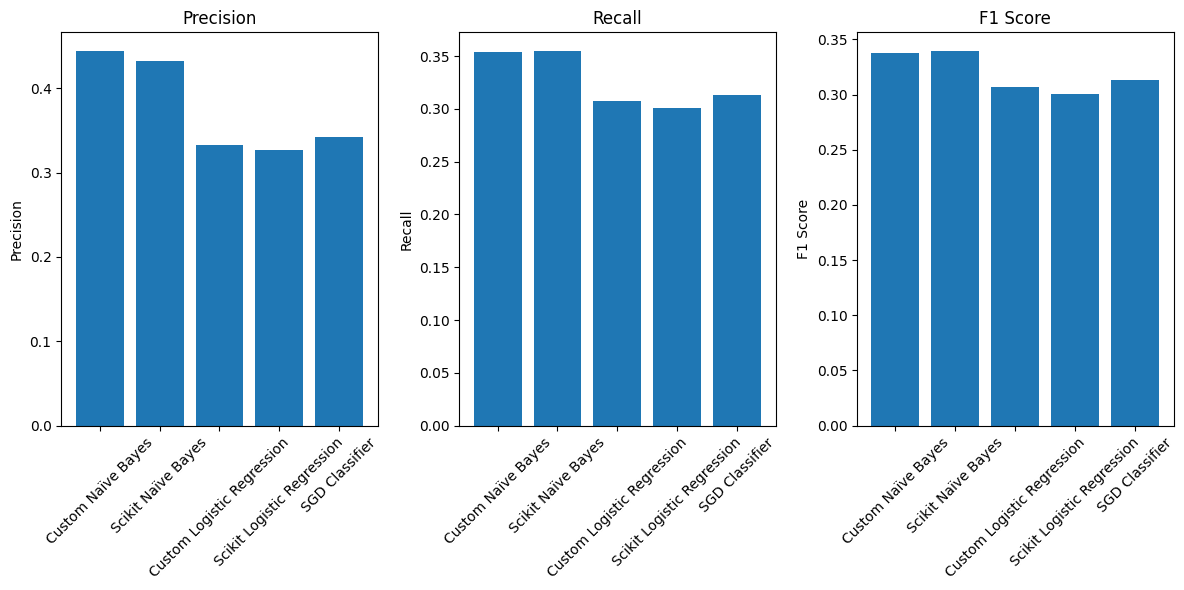

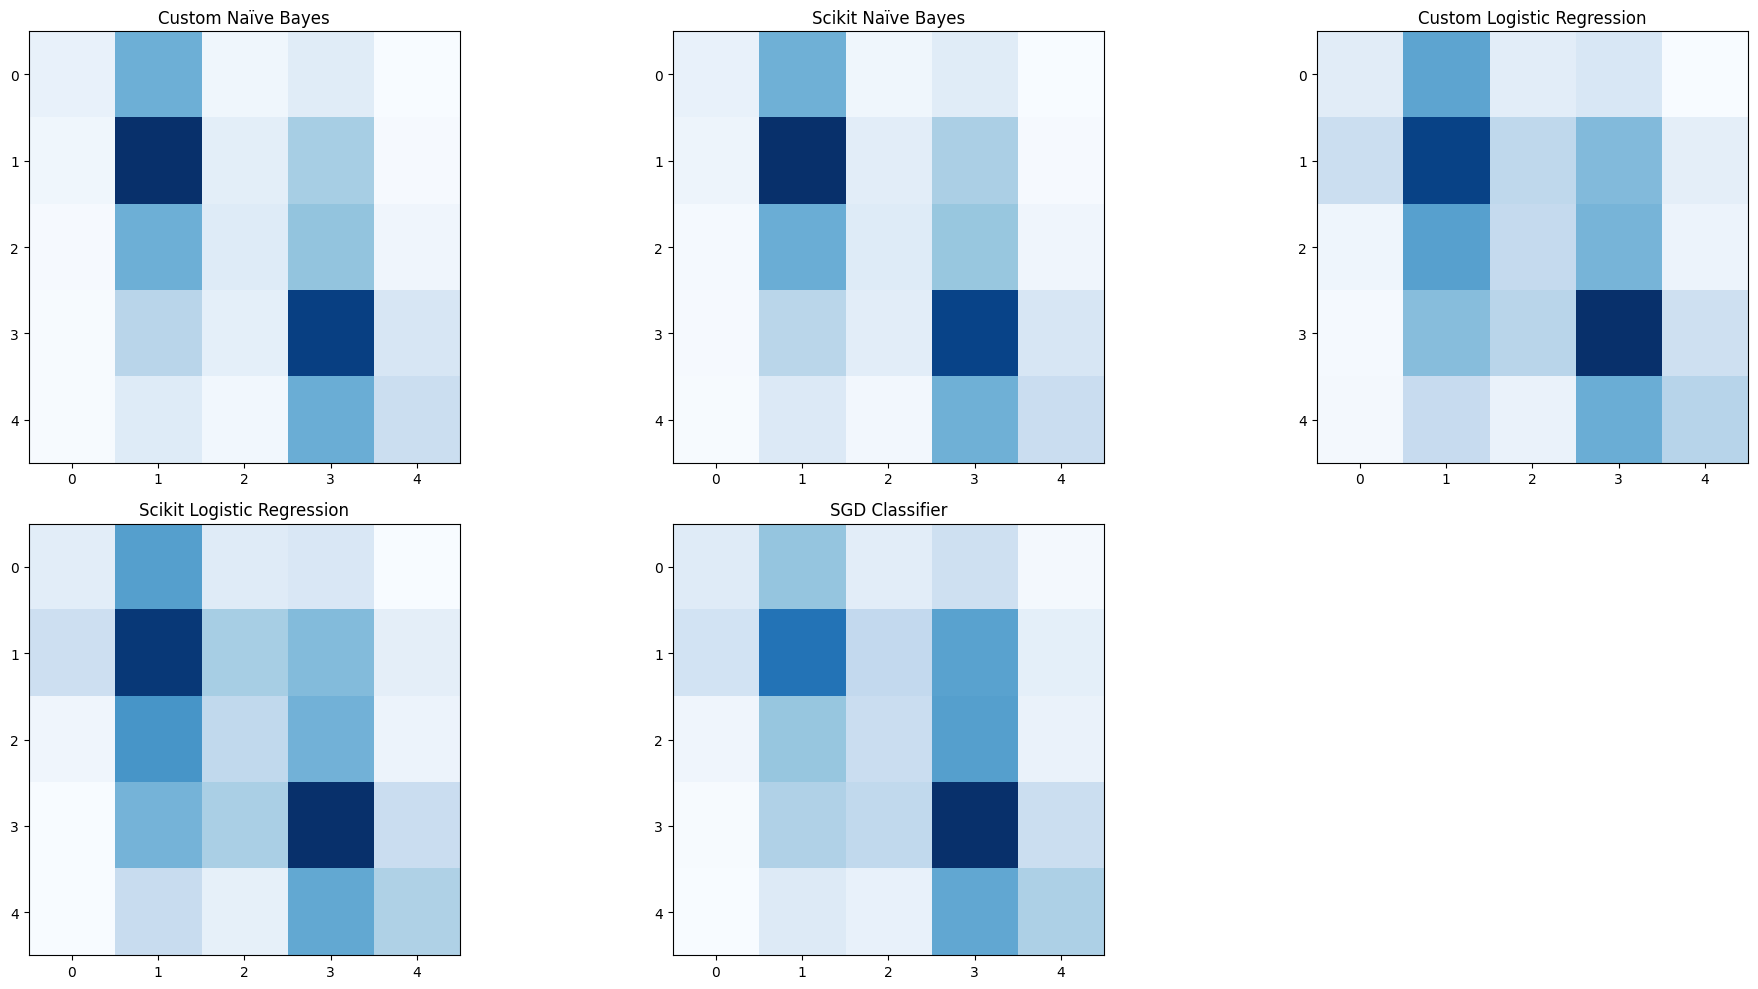

In [34]:
models = ["Custom Naïve Bayes", "Scikit Naïve Bayes", "Custom Logistic Regression", "Scikit Logistic Regression", "SGD Classifier"]

metrics = ["Precision", "Recall", "F1 Score"]

values = [

    [macro_precision_custom_naïve_bayes, macro_recall_custom_naïve_bayes, macro_f1_custom_naïve_bayes],

    [macro_precision_Scikit_naïve_bayes, macro_recall_Scikit_naïve_bayes, macro_f1_Scikit_naïve_bayes],

    [macro_precision_custom_logistic_regression, macro_recall_custom_logistic_regression, macro_f1_custom_logistic_regression],

    [macro_precision_logistic_regression, macro_recall_logistic_regression, macro_f1_logistic_regression],

    [macro_precision_sgd_classifier, macro_recall_sgd_classifier, macro_f1_sgd_classifier]

]



plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics):

    plt.subplot(1, 3, i + 1)

    plt.bar(models, [v[i] for v in values])

    plt.title(metric)

    plt.ylabel(metric)

    plt.xticks(rotation=45)

plt.tight_layout()

plt.show()



# plot the confusion matrix for all 5 models next to each other

plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)

plt.title("Custom Naïve Bayes")

plt.imshow(conf_matrix_custom_naïve_bayes, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 2)

plt.title("Scikit Naïve Bayes")

plt.imshow(conf_matrix_Scikit_naïve_bayes, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 3)

plt.title("Custom Logistic Regression")

plt.imshow(conf_matrix_custom_logistic_regression, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 4)

plt.title("Scikit Logistic Regression")

plt.imshow(conf_matrix_logistic_regression, cmap="Blues", interpolation="nearest")

plt.subplot(2, 3, 5)

plt.title("SGD Classifier")

plt.imshow(conf_matrix_sgd_classifier, cmap="Blues", interpolation="nearest")

plt.tight_layout()

plt.show()